In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt

from lib.layers import Dense
from lib.activations import Sigmoid, Tanh
from lib.losses import MSE
from lib.network import Sequential


# Section 1 — Gradient Checking
This section verifies our backpropagation implementation using numerical approximation.


In [3]:
def numerical_gradient_W(layer, X, y, loss_fn, model, epsilon=1e-5):
    num_grad = np.zeros_like(layer.W)

    base_out = model.forward(X)
    base_loss = loss_fn.forward(y, base_out)

    for i in range(layer.W.shape[0]):
        for j in range(layer.W.shape[1]):
            layer.W[i, j] += epsilon
            loss_plus = loss_fn.forward(y, model.forward(X))

            layer.W[i, j] -= 2*epsilon
            loss_minus = loss_fn.forward(y, model.forward(X))

            layer.W[i, j] += epsilon  # restore
            num_grad[i, j] = (loss_plus - loss_minus) / (2*epsilon)

    return num_grad


# tiny test network
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

model = Sequential([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Sigmoid()
])
loss_fn = MSE()
lr = 1.0

# forward + backward to compute analytical gradient
out = model.forward(X)
loss = loss_fn.forward(y, out)
grad = loss_fn.backward(y, out)
model.backward(grad, lr)

dense0 = model.layers[0]

num_grad_W = numerical_gradient_W(dense0, X, y, loss_fn, model)
anal_grad_W = dense0.grad_W

print("Max absolute difference:", np.max(np.abs(num_grad_W - anal_grad_W)))


Max absolute difference: 0.007843337114196856


# Section 2 — XOR using MSE Loss
Training a small 2-4-1 network to learn XOR logic function.


In [4]:
# XOR Dataset
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

model = Sequential([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Sigmoid()
])

loss_fn = MSE()
lr = 1.0
epochs = 50000

loss_history = []

for epoch in range(epochs + 1):
    out = model.forward(X)
    loss = loss_fn.forward(y, out)
    loss_history.append(loss)

    grad = loss_fn.backward(y, out)
    model.backward(grad, lr)

print("Predictions:")
print(model.forward(X))
print("Final Loss:", loss)


Predictions:
[[0.00135324]
 [0.99616787]
 [0.99667975]
 [0.00392499]]
Final Loss: 1.0736730125657572e-05


# Section 3 — Loss Curve
Visualizing convergence during training.


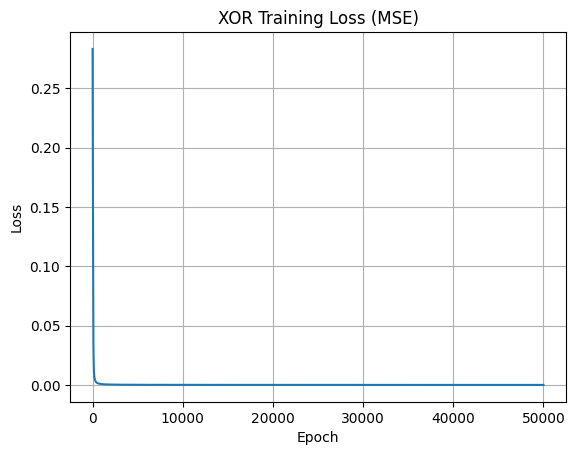

In [5]:
plt.plot(loss_history)
plt.title("XOR Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
